In [1]:
import os
import torch
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import models.ae as ae

In [2]:
weights_dir = 'weights/'
weights_path = os.path.join(weights_dir, 'ae_best.pth.tar')

data_dir = 'images/'
image_path = os.path.join(data_dir, 'data_0165.png')
label_path = os.path.join(data_dir, 'data_0165_label.png')
query_patch_path = os.path.join(data_dir, 'data_0165_mito_crop.png')

In [3]:
image = imageio.imread(image_path)
label = imageio.imread(label_path)
query_patch = imageio.imread(query_patch_path)

In [4]:
model = ae.AE(32)
model.load_state_dict(torch.load(weights_path)['state_dict'])
model.eval()
# model = model.cuda()

AE(
  (zeropad1): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (zeropad2): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (zeropad3): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_enc): Linear(in_features=2048, out_features=32, bias=True)
  (fc_dec): Linear(in_features=32, out_features=2048, bias=True)
  (t_conv1): ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
  (loss): BCELoss()
)

In [5]:
def calculate_ssd(img1, img2):
    """Computing the sum of squared differences (SSD) between two images."""
    if img1.shape != img2.shape:
        raise Exception("Images don't have the same shape: ", img1.shape, "and", img2.shape)
    return np.sum((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32))**2)

In [6]:
def compute_descriptor(descr, patch):
    variational = False  # isinstance(descr, vae.BetaVAE) or isinstance(descr, vae_ir.BetaVAE)
    patch = np.array(patch)
    patch = patch / 255.0
    patch = np.expand_dims(np.expand_dims(patch, axis=0), axis=0)
    patch = torch.from_numpy(patch).float()
    if variational:
        patch_encoding, _, _ = descr.encode(patch)
    else:
        patch_encoding = descr.encode(patch)
    patch_encoding = patch_encoding.detach().numpy()
    patch_encoding = patch_encoding.reshape(patch_encoding.shape[0], np.product(patch_encoding.shape[1:]))
    return patch_encoding[0]

In [7]:
patch_size = 65
compare_stride = 8
eps = 0.0001
nr_similar_patches = 6


image_height = image.shape[0]
image_width = image.shape[1]

query_patch_descr = compute_descriptor(model, query_patch)

counter_compare_patches = 0

patches_diffs = [1000000000]
patches_x_coords = [-1]
patches_y_coords = [-1]
patches_positions = [-1]


for y_compare in range(0, image_width - patch_size + 1, compare_stride):
    for x_compare in range(0, image_height - patch_size + 1, compare_stride):

        compare_patch = image[x_compare: x_compare + patch_size, y_compare: y_compare + patch_size]

        compare_patch_descr = compute_descriptor(model, compare_patch)

        diff = calculate_ssd(query_patch_descr, compare_patch_descr)

        if diff < eps:  # or (x_compare == x_query and y_compare == y_query):
            counter_compare_patches += 1
            continue

        # sorting
        for i in range(len(patches_diffs)):
            if diff < patches_diffs[i]:
                patches_diffs.insert(i, diff)
                patches_x_coords.insert(i, x_compare)
                patches_y_coords.insert(i, y_compare)
                patches_positions.insert(i, counter_compare_patches)
                break

        counter_compare_patches += 1

results_patches_diffs = patches_diffs[:nr_similar_patches]
results_patches_x_coords = patches_x_coords[:nr_similar_patches]
results_patches_y_coords = patches_y_coords[:nr_similar_patches]
results_patches_positions = patches_positions[:nr_similar_patches]

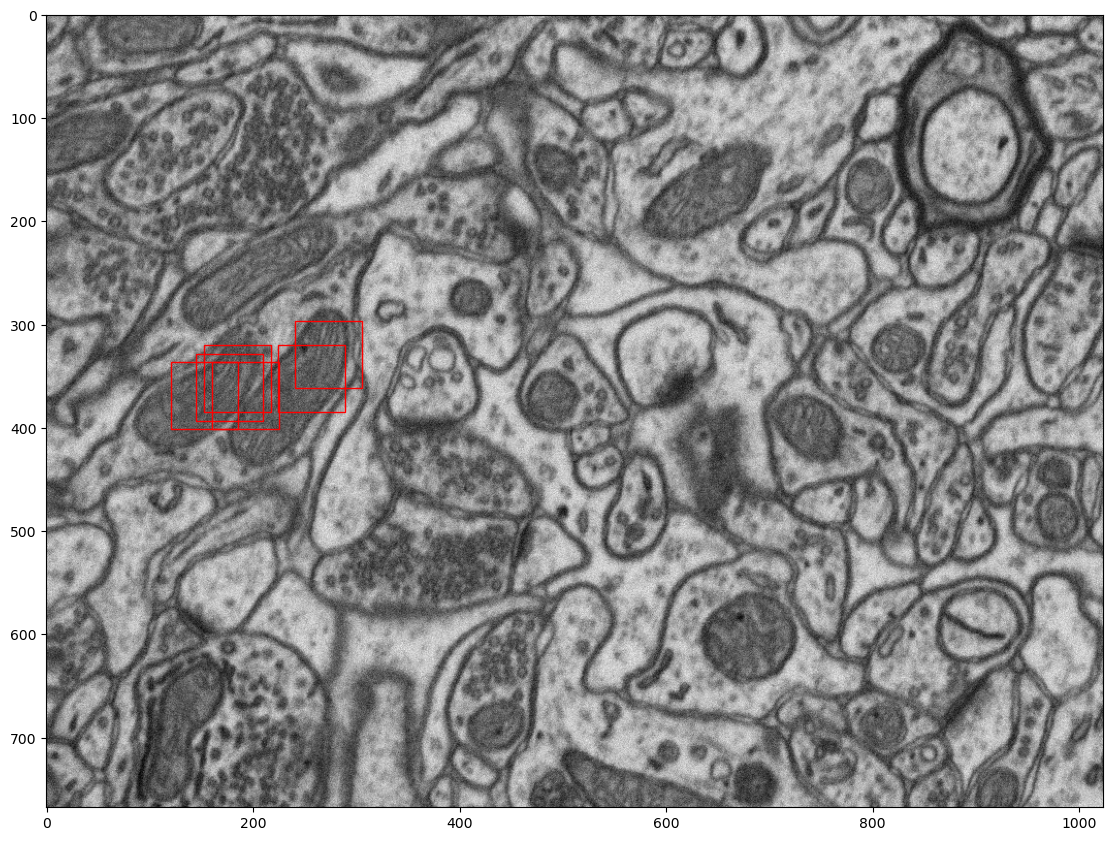

In [8]:
fig, ax = plt.subplots(1)
fig.set_size_inches(18.5, 10.5)
fig.set_dpi(100)
ax.imshow(image, cmap='gray')

for i, patch_match in enumerate(results_patches_positions):
    rect = patches.Rectangle((results_patches_y_coords[i], results_patches_x_coords[i]),
                             65, 65, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()

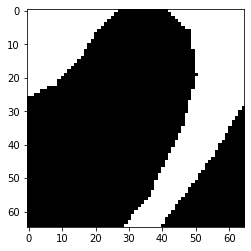

0.6809467455621302



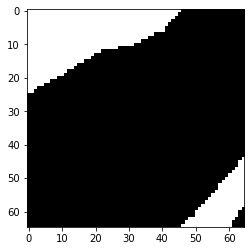

0.8087573964497041



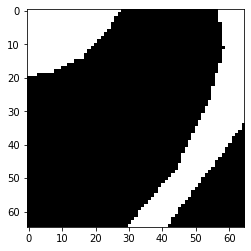

0.7538461538461538



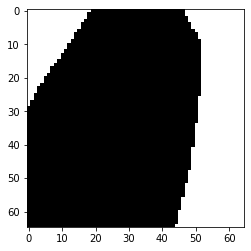

0.6946745562130178



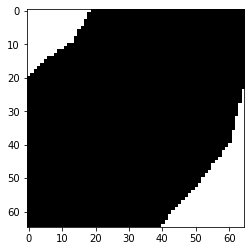

0.8504142011834319



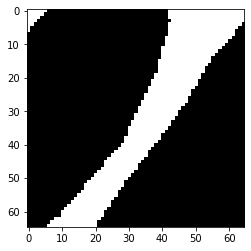

0.7784615384615384



In [9]:
maximum_correct_pixels = patch_size**2

for i, patch_match in enumerate(results_patches_positions):
    patch_match_label = label[results_patches_x_coords[i]: results_patches_x_coords[i] + patch_size,
                              results_patches_y_coords[i]: results_patches_y_coords[i] + patch_size]
    plt.imshow(patch_match_label, cmap='gray')
    plt.show()
    correct_pixels = np.sum(patch_match_label == 1)
    print(correct_pixels/maximum_correct_pixels)
    print()